# Branch Support

This notebook accomplishes the following things:

1. Plot the distribution of confidence values (aLRT and UFboot).
1. Plot the phylogeny with branches colored by whether they surpass the joint confidence threshold hold.
1. Exports the tree and node data to a json for nextstrain (augur/auspice).

---
# Setup

1. Initialize variables related to paths, constants, and plotting aesthetics.
1. Read input files (tree and dataframe).

### Import modules

In [2]:
import os
from Bio import Phylo
import matplotlib.pyplot as plt
from matplotlib import gridspec, lines
import seaborn as sns
import math
import pandas as pd
import augur

### Input file paths

In [3]:
tree_path = "../../docs/results/latest/parse_tree/parse_tree.xml"
tree_df_path = "../../docs/results/latest/parse_tree/parse_tree.tsv"
outdir = "../../docs/results/latest/branch_support/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### General Configuration

In [5]:
from config import *

SCRIPT_NAME = "branch_support"

### Read input tree

In [6]:
tree = Phylo.read(tree_path, "phyloxml")
tree.ladderize(reverse=False)

tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

tree_df

,UFboot,aLRT,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample
Name,,,,,,,,,,,,,,,,,,,
NODE0,100,100,0.000000e+00,red,0.000000,16.975763,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.891500e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age Plague,Bronze Age,Bronze Age,SAMEA3541827
NODE2,100,81.3,1.370850e-05,red,0.000014,2.968750,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.760700e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age Plague,Bronze Age,Bronze Age,SAMEA104233046
NODE4,100,100,1.114500e-06,red,0.000015,3.937500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000269265.1_ASM26926v1_genomic,NA,NA,4.688000e-07,grey,0.000076,520.000000,PY-36,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141469
GCA_000269385.1_ASM26938v1_genomic,NA,NA,2.340000e-08,grey,0.000075,521.000000,PY-66,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141487
NODE1041,100,97.9,1.172000e-06,red,0.000076,522.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


---
## Plot

### Color branches according to branch support

In [6]:
for c in tree.find_clades():
    c.color = tree_df["Branch_Support_Color"][c.name]

### Optional: Color branches according to UFboot only

In [7]:
"""for c in tree.find_clades():
    c.color = LOW_COL
    if c.is_terminal():
        c.color = TERM_COL
    for conf in c.confidences:
        if conf.type == "ufboot":
            if conf.value and conf.value >= UFBOOT_THRESH:
                c.color = HIGH_COL"""

'for c in tree.find_clades():\n    c.color = LOW_COL\n    if c.is_terminal():\n        c.color = TERM_COL\n    for conf in c.confidences:\n        if conf.type == "ufboot":\n            if conf.value and conf.value >= UFBOOT_THRESH:\n                c.color = HIGH_COL'

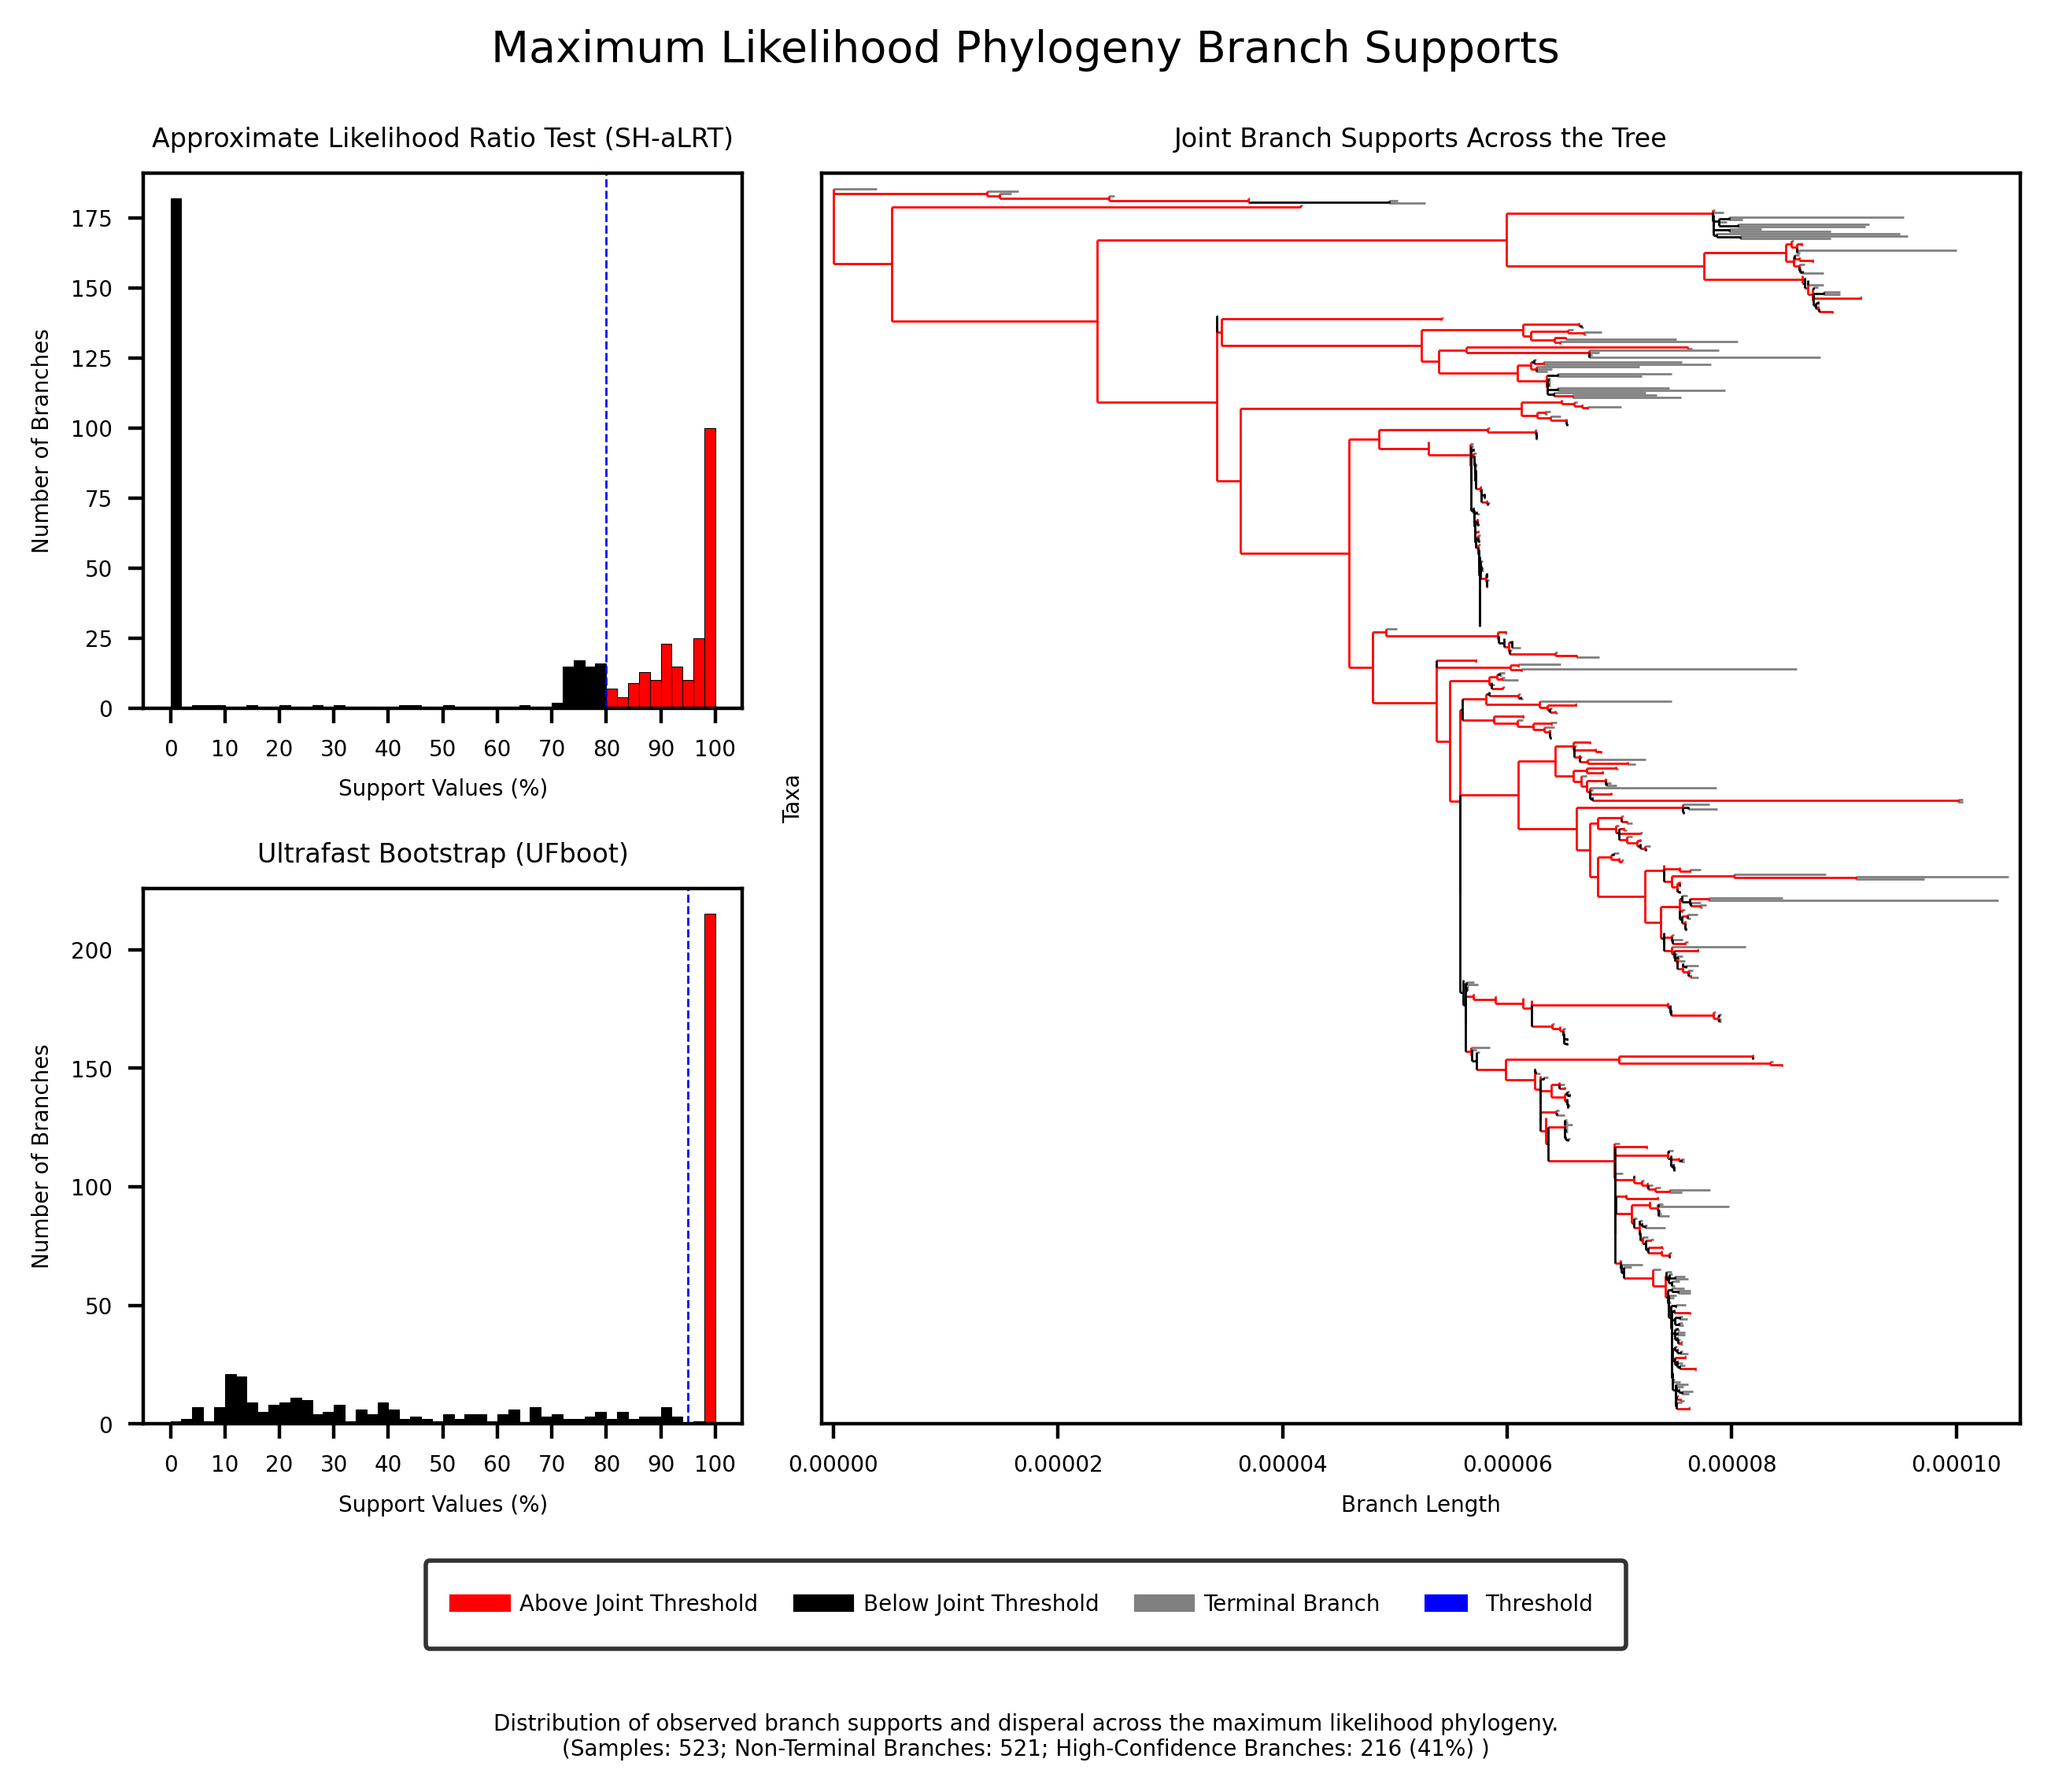

In [8]:
fig = plt.figure(constrained_layout=True, 
                 dpi=dpi,
                 figsize=figsize)

# Setup the grid
gs = gridspec.GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0:, 1:3])

# Local plot variables
hist_bins = [x for x in range(0,101,2)]
xticks_major = [x for x in range(0,101,10)]

# Filter out NA values
data = tree_df[(tree_df['aLRT'] != NO_DATA_CHAR) & (tree_df['UFboot'] != NO_DATA_CHAR) ]

# -------------------------------
# aLRT Axis
sns.histplot(data, 
             x="aLRT", 
             ax=ax1,
             bins=hist_bins,
             hue="Branch_Support_Color",
             palette=[HIGH_COL, LOW_COL],
             legend=False,
             alpha=1)
ax1.axvline(x=ALRT_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
ax1.set_xticks(xticks_major, minor=False)
ax1.set_xticklabels(xticks_major)
ax1.set_xlabel("Support Values (%)")
ax1.set_ylabel('Number of Branches')
ax1.set_title('Approximate Likelihood Ratio Test (SH-aLRT)')

# -------------------------------
# UFboot Axis
sns.histplot(data, 
             x="UFboot", 
             ax=ax2,
             bins=hist_bins,
             hue="Branch_Support_Color",
             palette=[HIGH_COL, LOW_COL],
             legend=False,
             alpha=1)
ax2.axvline(x=UFBOOT_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
ax2.set_xticks(xticks_major, minor=False)
ax2.set_xticklabels(xticks_major)
ax2.set_ylabel('Number of Branches')
ax2.set_xlabel("Support Values (%)")
ax2.set_title('Ultrafast Bootstrap (UFboot)')

# -------------------------------
# Phylogeny
Phylo.draw(tree,
           axes=ax3,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )

# Test plot tips
#tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
#ax3.scatter(data=tip_data, x="coord_x", y="coord_y", s=0.5, c="grey")

ax3.set_xlabel('Branch Length')
ax3.set_ylabel('Taxa')
ax3.set_yticks([])
ax3.set_yticklabels([])

x_buffer = max(tree_df["coord_x"]) * 0.01
y_buffer = math.ceil(len(tree.get_terminals()) * 0.01)

ax3.set_xlim(0 - x_buffer, max(tree_df["coord_x"]) + x_buffer)
# Deepest nodes at top, means y top value is 0, and bottom is high
ax3.set_ylim(len(tree.get_terminals()) + y_buffer, 0 - y_buffer)
ax3.set_title("Joint Branch Supports Across the Tree")

# -------------------------------
# Figure title
fig.suptitle("Maximum Likelihood Phylogeny Branch Supports")

# -------------------------------
# Legend
legend_lines = [lines.Line2D([0], [0], color=HIGH_COL, lw=4),
                lines.Line2D([0], [0], color=LOW_COL, lw=4),
                lines.Line2D([0], [0], color=TERM_COL, lw=4),
                lines.Line2D([0], [0], color=THRESH_COL, lw=4, ls="--"),
               ]

legend_labels = ["Above Joint Threshold",
                 "Below Joint Threshold",
                 "Terminal Branch",
                 "Threshold"]

fig.legend(legend_lines, 
           legend_labels,
           ncol=len(legend_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.05),
           frameon=True,
           borderpad=1.5,
           edgecolor="black")

# -------------------------------
# Caption
num_terminal_nodes = len(tree_df[tree_df["Branch_Support_Color"] == TERM_COL])
num_internal_nodes = len(tree_df[tree_df["Branch_Support_Color"] != TERM_COL])
num_high_support = len(tree_df[tree_df["Branch_Support_Color"] == HIGH_COL])
num_low_support = len(tree_df[tree_df["Branch_Support_Color"] == LOW_COL])
perc_high_support = (num_high_support / num_internal_nodes) * 100

caption_text = ("Distribution of observed branch supports and disperal across the maximum likelihood phylogeny." 
                + "\n(" 
                + "Samples: {}".format(num_terminal_nodes) 
                + "; "
                + "Non-Terminal Branches: {}".format(num_internal_nodes)
                + "; "
                + "High-Confidence Branches: {0} ({1:.0f}%)".format(num_high_support, perc_high_support)
                + " )"
               )
fig.text(0.5, -0.15, caption_text, ha='center')

# -------------------------------
# Save figure
out_path = os.path.join(outdir, SCRIPT_NAME + "." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
## Export

### Save Data files

In [9]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")

out_path_xml = os.path.join(outdir, SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tree, out_path_xml, 'phyloxml')
Phylo.write(tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Test

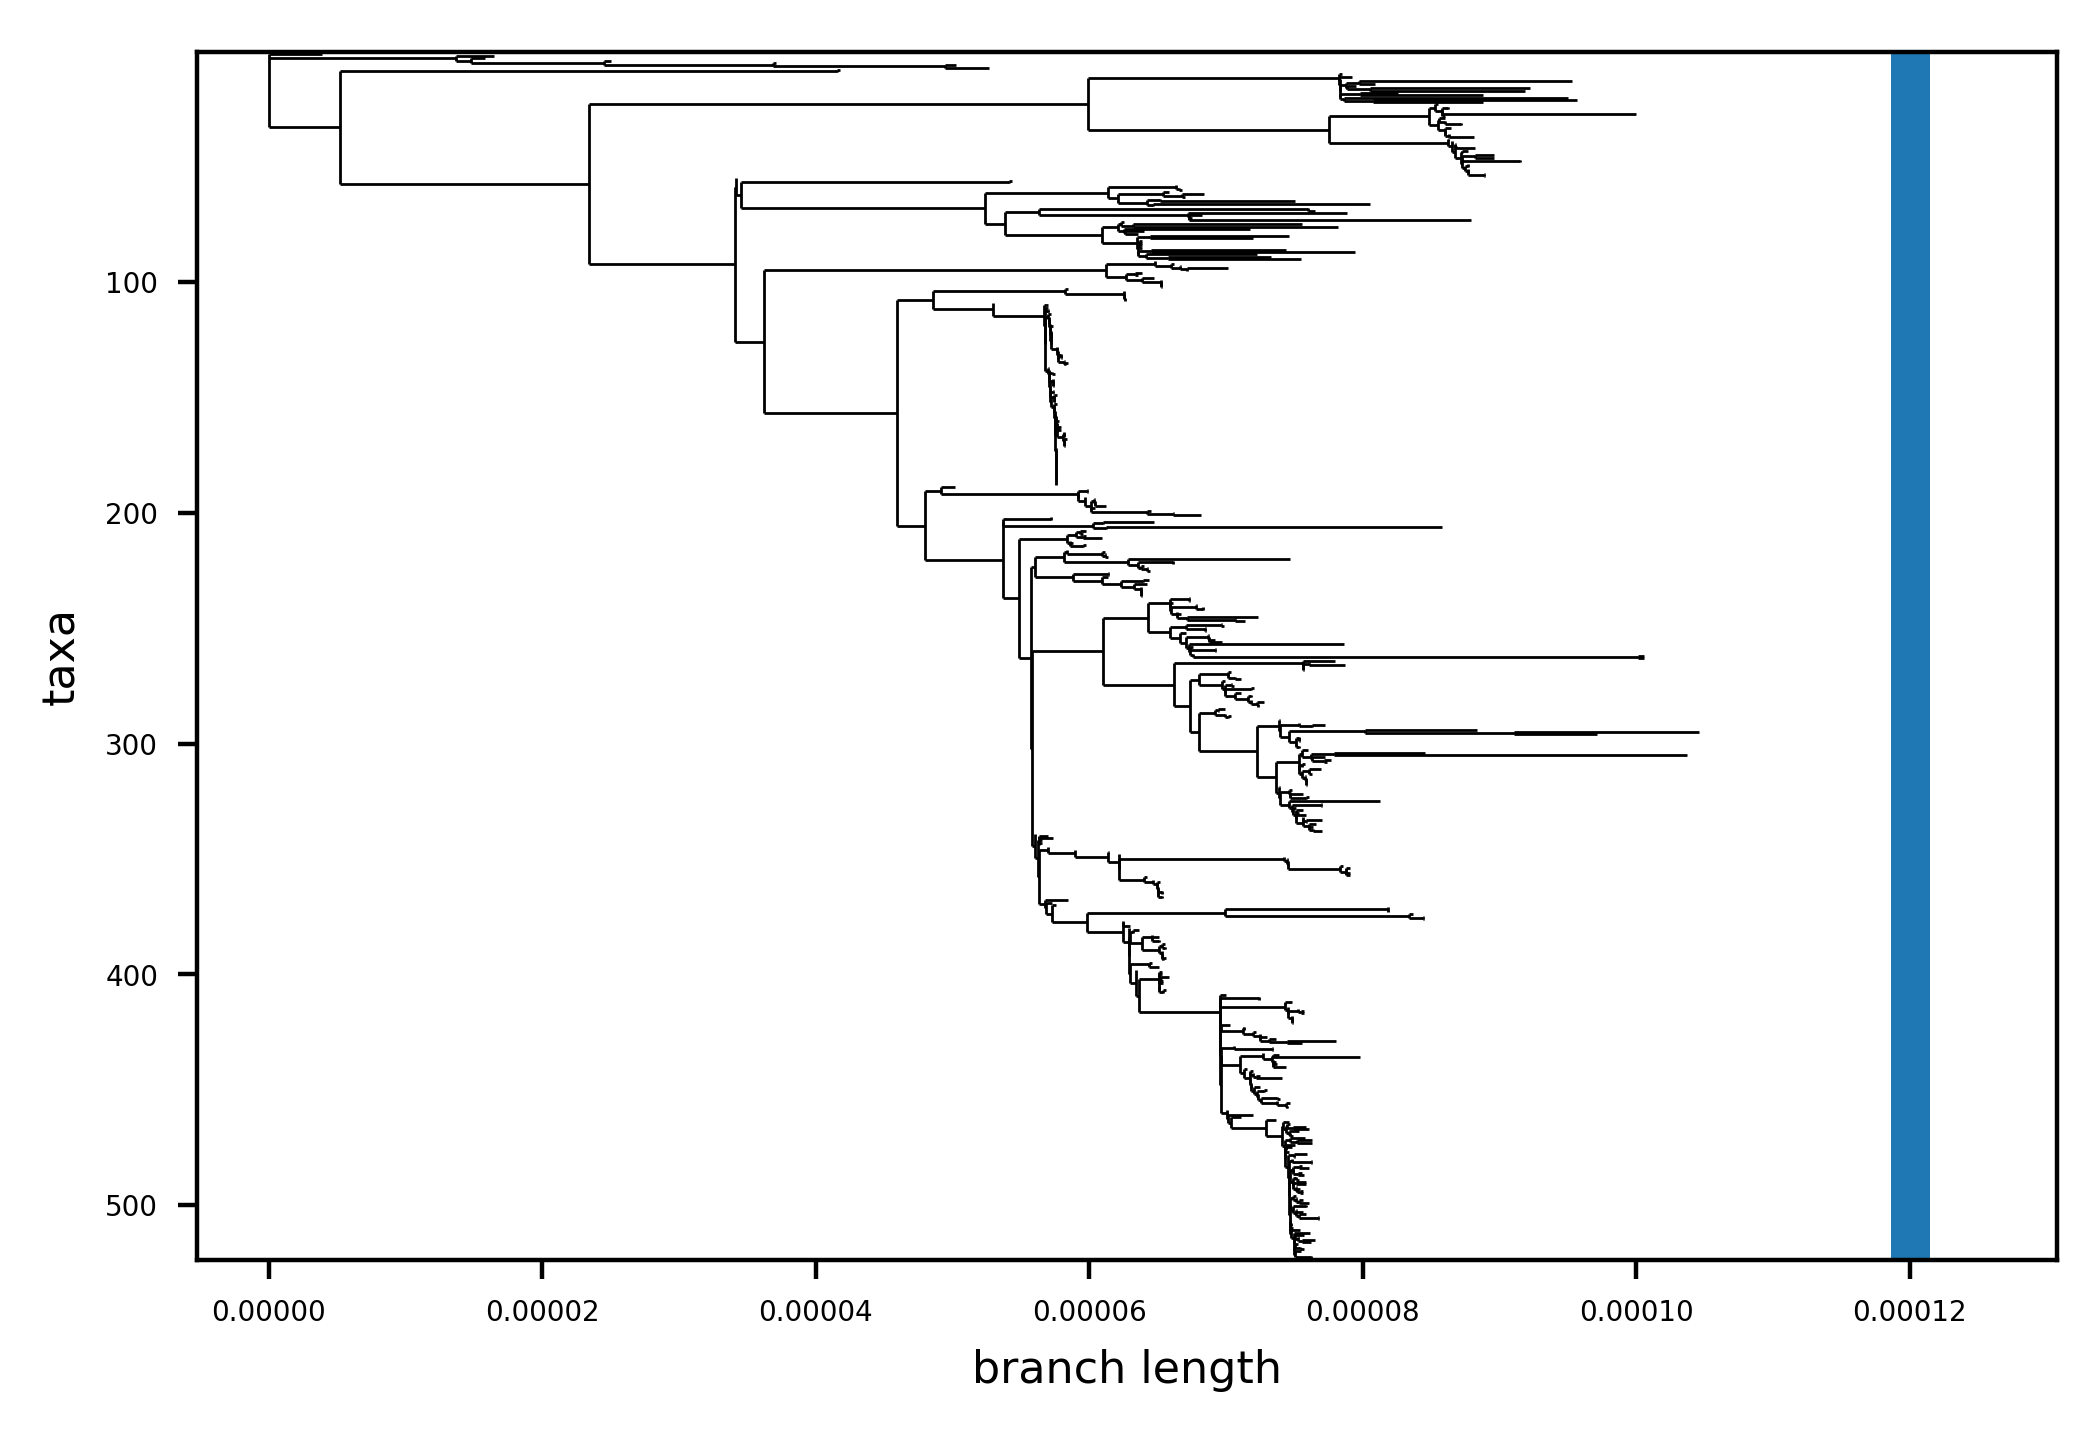

In [19]:
fig, ax1 = plt.subplots(1, dpi=dpi)

Phylo.draw(tree,
           axes=ax1,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )

tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
#ax3.scatter(data=tip_data, x="coord_x", y="coord_y", s=0.5, c="grey")
heatmap_x = 0.00012
ax1.scatter(data=tip_data, 
            x=[heatmap_x for tip in tip_data["coord_y"]], 
            y="coord_y",
            )